# Florescent-Brightfield Linear Image Registration
This notebook is adapted from https://github.com/airlab-unibas/airlab/blob/master/examples/affine_registration_3d.py

- Fixed image: MD589
- Moving image: DK52

In [1]:
import airlab as al
import numpy as np
import torch

import utility as util

## Load images

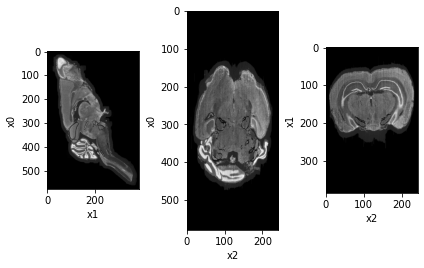

In [2]:
fixed_image = np.load('../data/fb/fixed_image.npy')
fixed_image = util.normalize_intensity(fixed_image)
util.imshow_midslice(fixed_image)

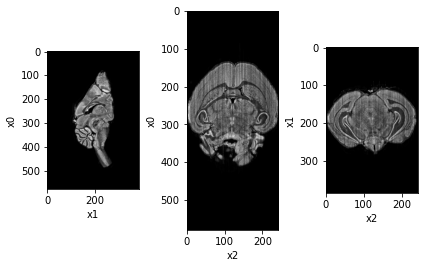

In [3]:
moving_image = np.load('../data/fb/moving_image.npy')
moving_image = util.normalize_intensity(moving_image)
util.imshow_midslice(moving_image)

## Prepare images for registration

In [4]:
dtype = torch.float32
device = torch.device('cpu')
scales = [1, 1, 1]

fixed_image = torch.tensor(fixed_image, dtype=dtype).to(device)
fixed_image = al.Image(fixed_image, fixed_image.shape, scales, [0, 0, 0])
moving_iamge = torch.tensor(moving_image, dtype=dtype).to(device)
moving_image = al.Image(moving_image, moving_image.shape, scales, [0, 0, 0])

## Prepare image pyramid

In [5]:
scales = [[4, 4, 4], [2, 2, 2]]

fixed_image_pyramid = al.create_image_pyramid(fixed_image, scales)
moving_image_pyramid = al.create_image_pyramid(moving_image, scales)

## Run registration

In [6]:
lr = 5e-3
niter = [64, 16, 4]

In [7]:
import time

start = time.time()

for level, (mov_im, fix_im) in enumerate(zip(moving_image_pyramid, fixed_image_pyramid)):
    print('level', level)
    registration = al.PairwiseRegistration(verbose=True)
    
    transformation = al.transformation.pairwise.AffineTransformation(mov_im)
    if level == 0:
        transformation.init_translation(fix_im)
    else:
        transformation.set_parameters(**parameters)
    registration.set_transformation(transformation)
    
    image_loss = al.loss.pairwise.MSE(fix_im, mov_im)
    registration.set_image_loss([image_loss])
    
    optimizer = torch.optim.Adam(transformation.parameters(), lr=lr)
    registration.set_optimizer(optimizer)
    
    registration.set_number_of_iterations(niter[level])
    registration.start()
    
    parameters = {
        't': (
            float(transformation._t_x),
            float(transformation._t_y),
            float(transformation._t_z)
        ),
        'phi': (
            float(transformation._phi_z),
            float(transformation._phi_x),
            float(transformation._phi_y),
        ),
        'scale': (
            float(transformation._scale_x),
            float(transformation._scale_y),
            float(transformation._scale_z)
        ),
        'shear': (
            float(transformation._shear_y_x),
            float(transformation._shear_x_y),
            float(transformation._shear_z_x),
            float(transformation._shear_z_y),
            float(transformation._shear_x_z),
            float(transformation._shear_y_z),
        ),
    }

end = time.time()
print((end - start) / 60, 'min')

level 0
0 mse: 0.014809169605530631 


/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


1 mse: 0.014454428058534257 
2 

/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


mse: 0.014211048072610795 
3 mse: 0.01391460603484338 
4 mse: 0.013616895884710595 
5 mse: 0.013448070697358844 
6 mse: 0.013285999316750247 
7 mse: 0.013131873785303871 
8 mse: 0.012943112850466796 
9 mse: 0.012721820850159347 
10 mse: 0.012487942028481979 
11 mse: 0.012265202838754322 
12 mse: 0.011988461783739286 
13 mse: 0.011750709562445366 
14 mse: 0.011537772025661489 
15 mse: 0.011333934405745866 
16 mse: 0.011132022691793232 
17 mse: 0.010934424905404047 
18 mse: 0.010743529721144765 
19 mse: 0.010558459361216674 
20 mse: 0.010383048250897815 
21 mse: 0.01021306754363873 
22 mse: 0.010051403055422134 
23 mse: 0.009900253717451584 
24 mse: 0.009756416218125794 
25 mse: 0.009614922597911586 
26 mse: 0.009476035435192853 
27 mse: 0.009341405924657452 
28 mse: 0.009209553258997513 
29 mse: 0.009088753137020126 
30 mse: 0.00897672335741023 
31 mse: 0.00887039567823911 
32 mse: 0.00876697013680142 
33 mse: 0.008660623028083882 
34 mse: 0.008548286646568426 
35 mse: 0.008429462309396

## Examine results

In [8]:
transformation.print()

_phi_z 0.07929578203784687
_t_x 0.004405255343036952
_t_y 0.1624020835272991
_t_z -0.02800426403470454
_phi_x 0.38228268271735394
_phi_y -0.0750660904740612
_scale_x 1.041537542989202
_scale_y 0.7722472280453909
_scale_z 0.7927520929754949
_shear_y_x 0.11875616467960891
_shear_x_y -0.14095190898357773
_shear_z_x -0.1127319303099942
_shear_z_y -0.3208253612098304
_shear_x_z -0.034654539722768905
_shear_y_z -0.08080676749434401


In [9]:
displacement = transformation.get_displacement()
warped_image = al.transformation.utils.warp_image(moving_image, displacement)
np.save('../data/fb/moving_image_after_linear_reg.npy', warped_image.image[0,0].numpy())

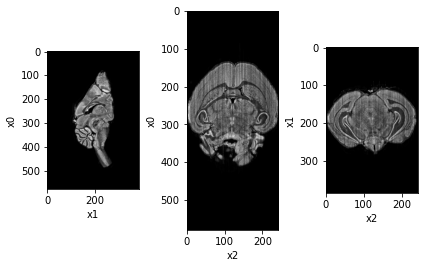

In [10]:
util.imshow_midslice(moving_image.image[0,0].numpy())

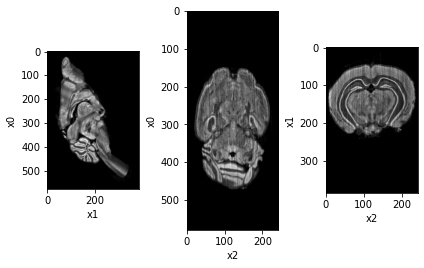

In [11]:
util.imshow_midslice(warped_image.image[0,0].numpy())

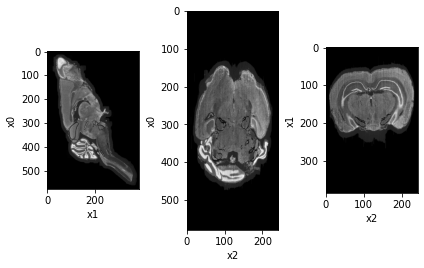

In [12]:
util.imshow_midslice(fixed_image.image[0,0].numpy())